Adapted in notebook GP_S+L pulse_kernel_mixture_of_2_terms:
- Use data file sim_pulse.lc
- Use the two SHOTerms of the step by step notebook

In [14]:
import math
%load_ext autoreload
%autoreload 2

import numpy as np
np.random.seed(0)

# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from spleaf import cov, term
from scipy.optimize import fmin_l_bfgs_b

import pandas as pd
pd.set_option('precision', 0)
pd.set_option('display.float_format', lambda x: '%.16f' % x)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# Make the notebook use the whole screen width
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

Read the first time series

In [16]:
df = pd.read_csv("../../data/sim_pulse.lc",sep=' ', header = None, names=['Time', 'Lc'], index_col=False, float_precision='round_trip')

In [17]:
X, Y = df['Time'].tolist(), df['Lc'].tolist()
X, Y = np.array(X), np.array(Y)

# 1. Exploratory
## Plot the data

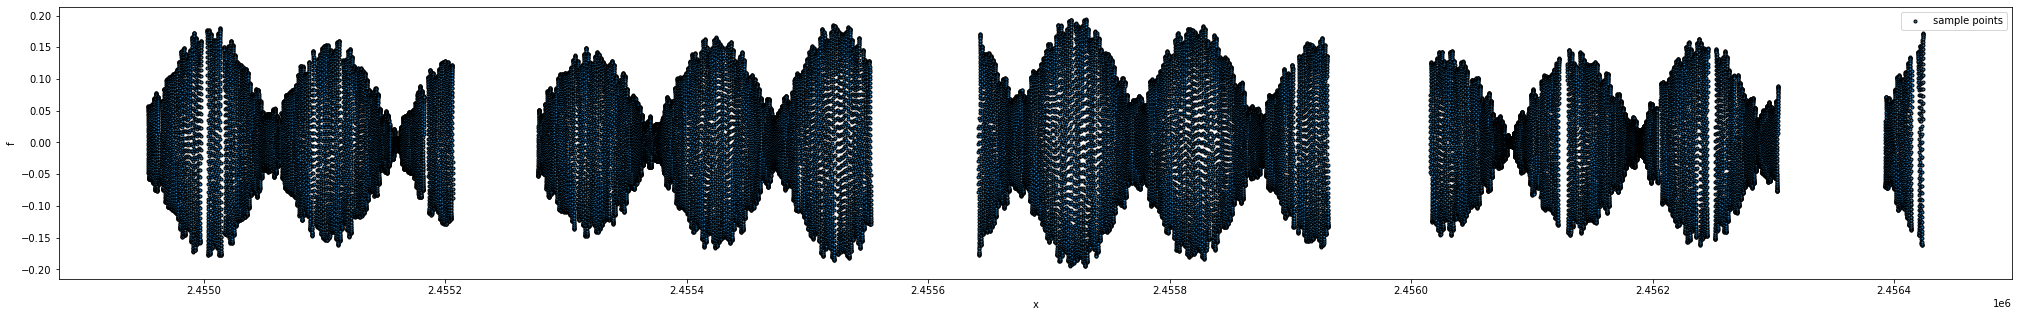

In [18]:
# Setup our figure environment
plt.figure(figsize=(35, 5))

# Plot observations
plt.plot(X, Y, ".", mew=1, linewidth=1, mec="black")

# Annotate plot
plt.xlabel("x"), plt.ylabel("f")
plt.legend(labels=["sample points"]);

Zoomed in on the first N observations

In [19]:
# This library becomes unstable at N=15125
# N=15125
N=X.shape[0]
N_part=15000

In [20]:
X_part=X[:N_part]
Y_part=Y[:N_part]

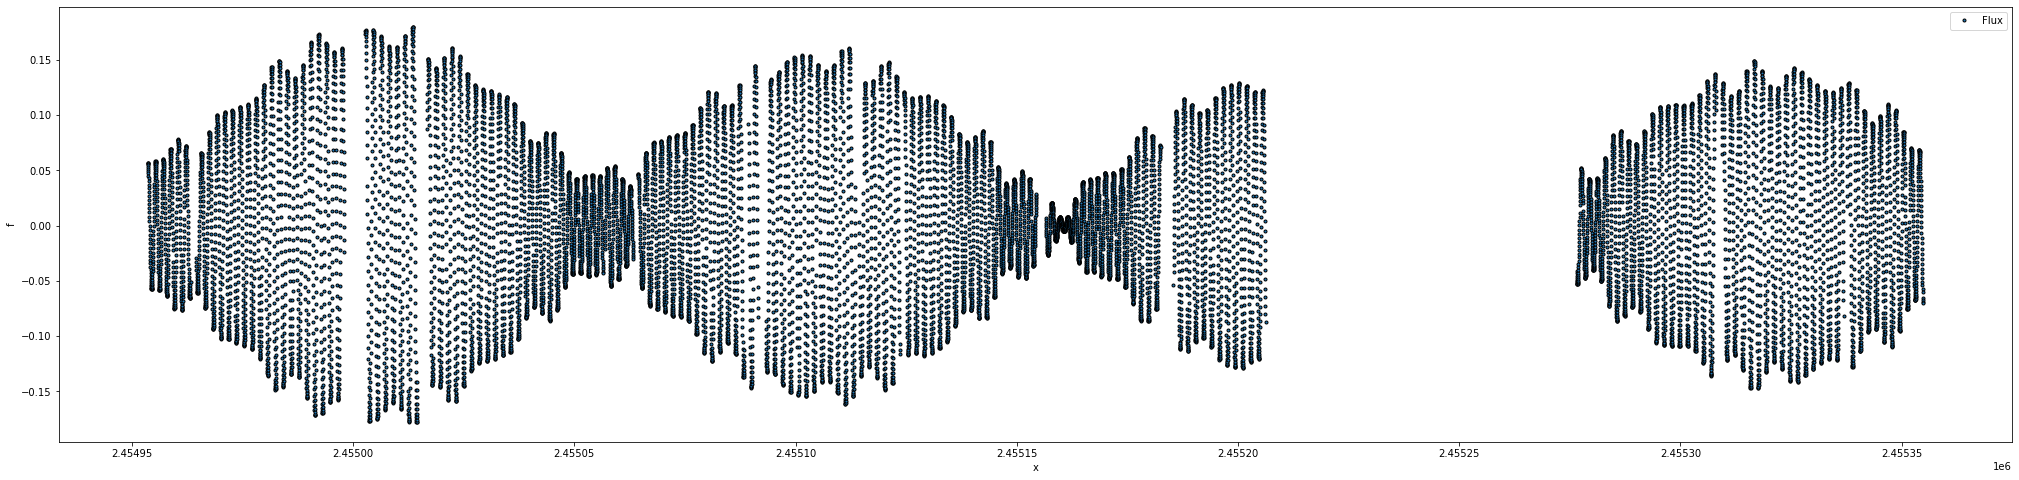

In [21]:
# Setup our figure environment
plt.figure(figsize=(35, 8))

# Plot observations
plt.plot(X_part, Y_part, ".", mew=1, linewidth=1, mec="black")

# Annotate plot
plt.xlabel("x"), plt.ylabel("f")
plt.legend(labels=["Flux"]);

# 2. Processing


Compose a Gaussian Process from a reasonable guess of kernels

In [22]:
def plot_kernel_samples(covariance_matrix, nr_of_samples=5):
    plt.figure(figsize=(35, 8))
    Y_sample = covariance_matrix.sample(nr_of_samples)
    N = cov_matrix.W.shape[0]
    for i in range(nr_of_samples):
        plt.plot(range(N), Y_sample[i])

def plot_kernel(covariance_matrix):
    # Our sample space
    X = np.linspace(-5., 5., 250)[:, None]
    C = covariance_matrix.chi2(X)
      
    # Visualise covariance matrix on right hand side
    plt.pcolor(X.T, X, C)
    # Annotate plot
    plt.gca().invert_yaxis(), plt.gca().axis("image")
    plt.colorbar()
    
def plot_series(data_x, data_y, smooth_x=None, smooth_y=None, var=None):
    # Plot
    plt.figure(figsize=(35, 8))
    plt.plot(data_x, data_y, ".", mew=1, linewidth=1, mec="black", label='truth')
    #plt.plot(tsmooth, ysignal, 'r', label='truth')
    #plt.errorbar(t, y, yerr, fmt='.', color='k', label='meas.')
    if not smooth_x is None:
        plt.fill_between(smooth_x, smooth_y-np.sqrt(var), smooth_y+np.sqrt(var), color='g', alpha=0.5)
        plt.plot(smooth_x, smooth_y, 'r', label='predict.')
    plt.xlabel('t')
    plt.ylabel('y')
    plt.legend()

In [23]:
# Predict evenly spaced points on our time-axis
X_part_smooth = np.linspace(X_part.min(), X_part.max(), N_part)

In [24]:
# Define the function to minimize
def negloglike(x, y, cov_matrix):
   cov_matrix.set_param(x)
   nll = -cov_matrix.loglike(y)
   # gradient
   nll_grad = -cov_matrix.loglike_grad()[1]
   return(nll, nll_grad)

In [38]:
# Initialize the S+LEAF model
cov_matrix = cov.Cov(X_part,
   sho1 = term.SHOKernel(sig=-0.28934701533858714, P0=1/0.5673, Q=200000.36505),
   sho2 = term.SHOKernel(sig=-2.974640118235212e-09, P0=1.7937, Q=200000.36505),
   sho3 = term.SHOKernel(sig=-4.314e-19, P0=1.7590, Q=200000.36505),
   sho4 = term.SHOKernel(sig=-4.314e-12, P0=1.7474, Q=200000.36505),
   sho5 = term.SHOKernel(sig=-4.314e-12, P0=0.8889, Q=200000.36505)
                    )

In [39]:
# We now fit the hyperparameters using the fmin_l_bfgs_b function from scipy.optimize.
# xbest,_,_ = fmin_l_bfgs_b(negloglike, cov_matrix.get_param(), args=(Y_part, cov_matrix))
# cov_matrix.set_param(xbest)

In [40]:
# We now use S+LEAF to predict the missing data on the training data scope
mu_part_smooth, var_part_smooth = cov_matrix.conditional(Y_part, X_part_smooth, calc_cov='diag')

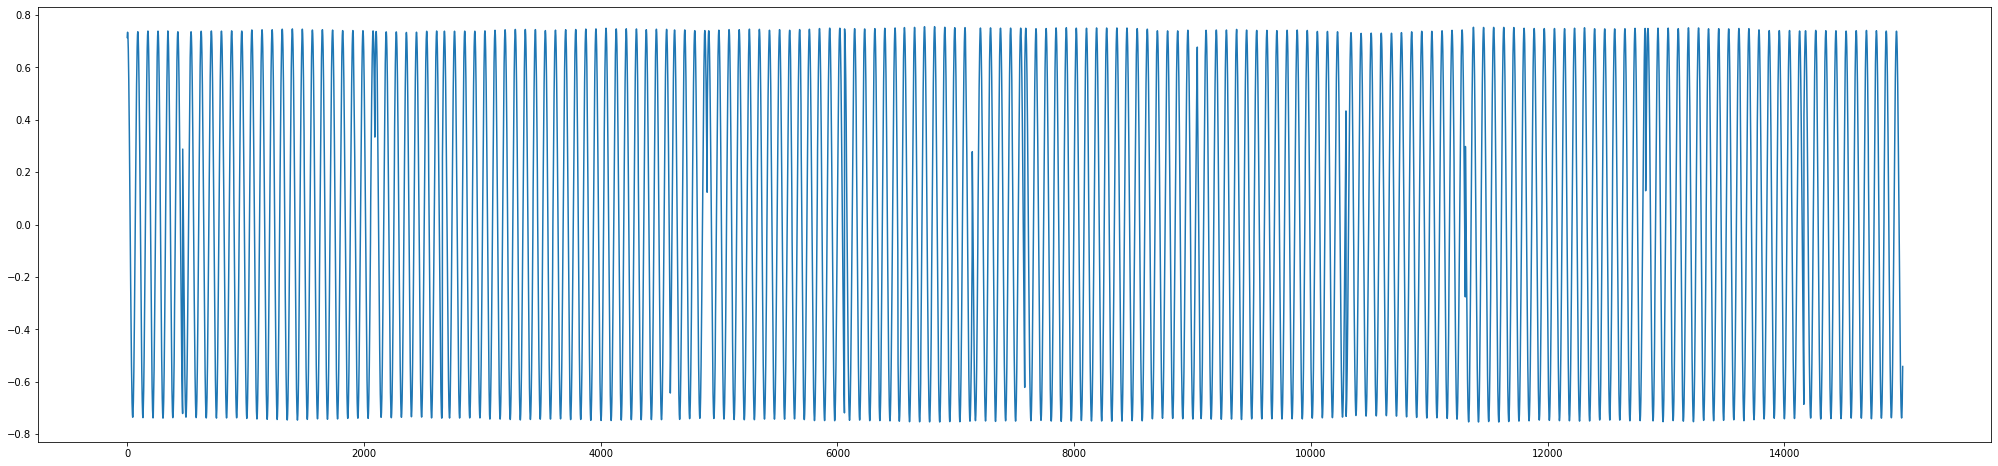

In [41]:
plot_kernel_samples(cov_matrix, 1)

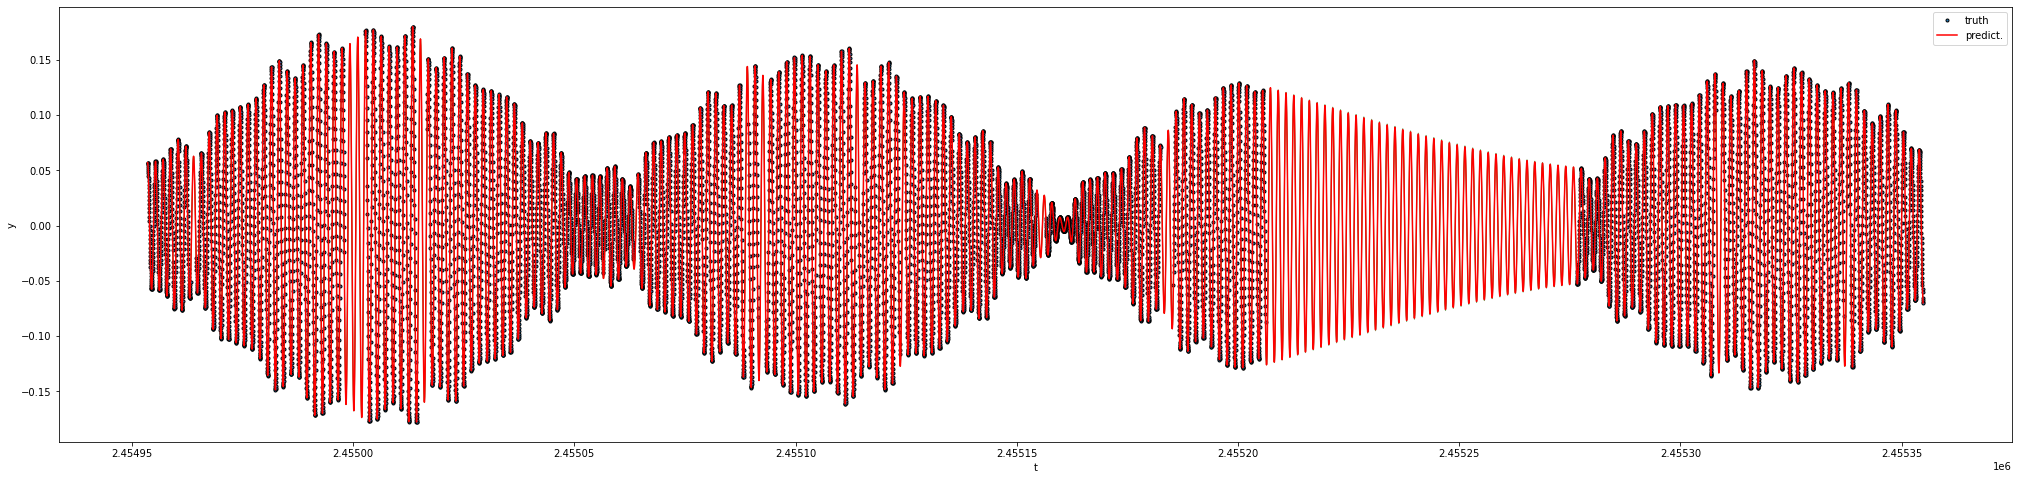

In [29]:
plot_series(X_part, Y_part, X_part_smooth, mu_part_smooth, var_part_smooth)

## Explore the parameters of the fitted model

In [30]:
cov_matrix.param

['sho1.sig',
 'sho1.P0',
 'sho1.Q',
 'sho2.sig',
 'sho2.P0',
 'sho2.Q',
 'sho3.sig',
 'sho3.P0',
 'sho3.Q',
 'sho4.sig',
 'sho4.P0',
 'sho4.Q',
 'sho5.sig',
 'sho5.P0',
 'sho5.Q']

In [31]:
cov_matrix.get_param('sho1.sig'), cov_matrix.get_param('sho1.P0'), cov_matrix.get_param('sho1.Q'),\
cov_matrix.get_param('sho2.sig'), cov_matrix.get_param('sho2.P0'), cov_matrix.get_param('sho2.Q')

(-0.056267, 1.7627357659086902, 200000.36505, -4.314e-10, 1.7937, 200000.36505)

## Model Evaluation

RMSE

In [32]:
mu_part, var_part = cov_matrix.conditional(Y_part, X_part, calc_cov='diag')

np.sqrt(np.nanmean((mu_part-Y_part)**2))

1.1553302821670544e-11

RMSE per x

In [33]:
np.sqrt(np.nanmean((mu_part-Y_part)**2))/N_part

7.702201881113696e-16

# Residuals

In [34]:
resid1_part = Y_part - mu_part

In [35]:
Y_part, mu_part, resid1_part

(array([ 0.0569707 ,  0.0567645 ,  0.05627531, ..., -0.06705571,
        -0.06870064, -0.07000665]),
 array([ 0.0569707 ,  0.0567645 ,  0.05627531, ..., -0.06705571,
        -0.06870064, -0.07000665]),
 array([-1.54029567e-13,  5.00093023e-13, -5.26814703e-13, ...,
         1.93255828e-11,  1.82470844e-11,  2.37912051e-11]))

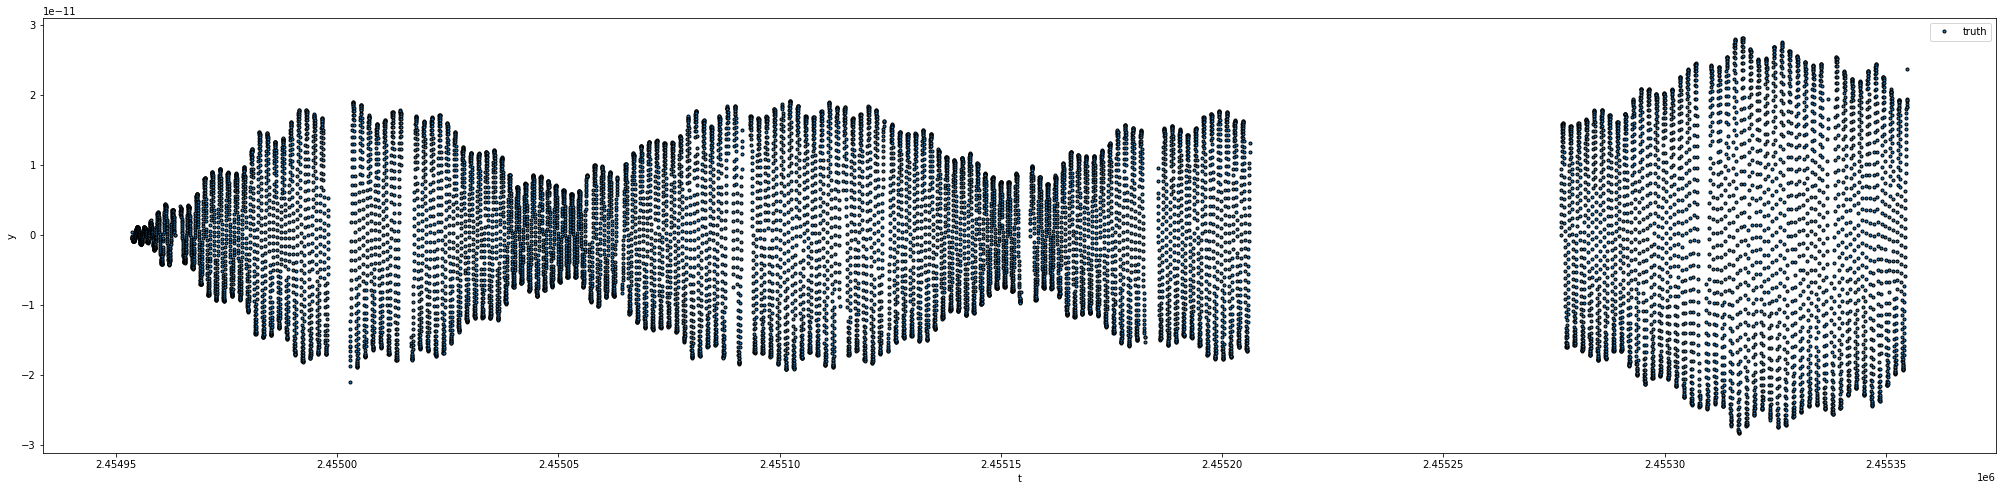

In [36]:
plot_series(X_part, resid1_part)

Strange that we do not get the same results as the step-by-step kernel!!

The residuals are very small compared to Y.
Yet, there is still a periodic signal, this is not stationary yet